<a href="https://colab.research.google.com/github/codrae/timeseries-dl-models/blob/main/AMPds2_processed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Electricity_B2E.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,unix_ts,V,I,f,DPF,APF,P,Pt,Q,Qt,S,St
0,1333263600,118.0,0.5,60.0,1.00,0.98,58,16640,2,2037,59,28157
1,1333263660,118.0,0.5,60.0,1.00,0.98,58,16641,2,2037,59,28158
2,1333263720,117.8,0.1,60.0,0.96,0.55,8,16642,2,2037,15,28159
3,1333263780,118.0,0.1,60.0,0.96,0.52,7,16642,2,2037,15,28159
4,1333263840,118.2,0.1,60.0,0.98,0.56,8,16642,1,2037,14,28159


In [ ]:
df['date'] = pd.to_datetime(df['unix_ts'], unit='s')
df = df.set_index('date')
df = df[['P']]

num_rows = len(df)
num_zeros = (df['P'] == 0).sum()
zero_percentage = (num_zeros / num_rows) * 100

num_missing = df['P'].isnull().sum()

print(f"전체 행의 수: {num_rows}")
print(f"0값의 개수: {num_zeros}")
print(f"0값의 비율: {zero_percentage:.2f}%")
print(f"결측치 수: {num_missing}")


전체 행의 수: 1051200
0값의 개수: 19538
0값의 비율: 1.86%
결측치 수: 0


In [ ]:
# 0값을 NaN으로 대체
df['P'] = df['P'].replace(0, np.nan)

# 선형 보간법 적용
df['P'] = df['P'].interpolate(method='linear')

# 다시 상태 체크
p_column = df['P']
num_zeros = (p_column == 0).sum()
total_rows = len(p_column)
zero_ratio = num_zeros / total_rows
num_missing = p_column.isnull().sum()

print(f"0값 개수: {num_zeros}")
print(f"전체 행 개수: {total_rows}")
print(f"0값 비율: {zero_ratio:.4f}")
print(f"결측치 개수: {num_missing}")


0값 개수: 0
전체 행 개수: 1051200
0값 비율: 0.0000
결측치 개수: 0


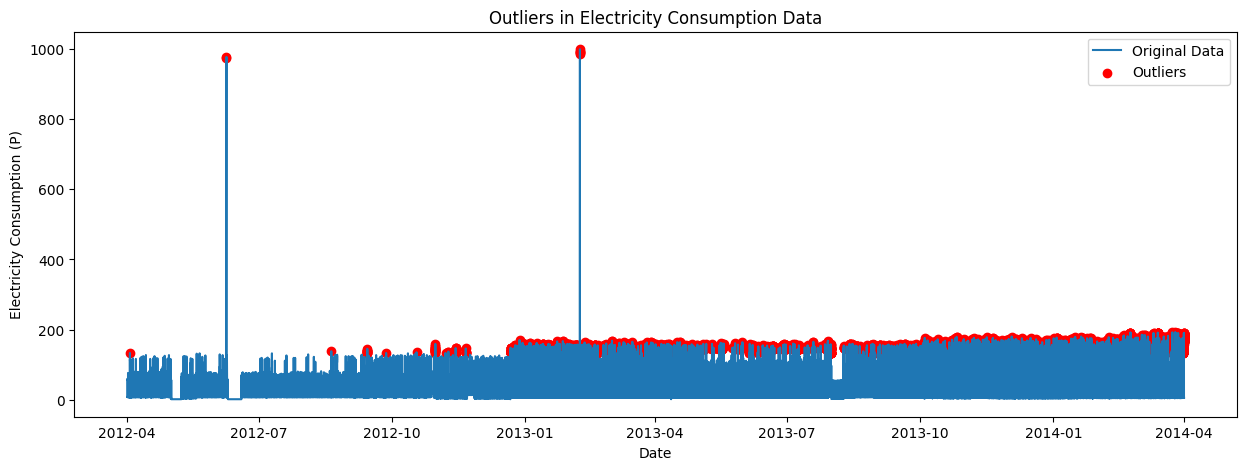

                            P
date                         
2012-04-01 07:00:00  9.516667
2012-04-01 08:00:00  7.466667
2012-04-01 09:00:00  7.316667
2012-04-01 10:00:00  7.416667
2012-04-01 11:00:00  7.500000
                             P
date                          
2014-04-01 02:00:00   5.000000
2014-04-01 03:00:00  60.382270
2014-04-01 04:00:00  63.569149
2014-04-01 05:00:00  39.340248
2014-04-01 06:00:00   5.000000


In [ ]:
# Z-score 계산
df['z_score'] = (df['P'] - df['P'].mean()) / df['P'].std()

# Z-score가 3 초과인 데이터 확인
outliers = df[df['z_score'] > 3]

# 이상치 시각화
plt.figure(figsize=(15, 5))
plt.plot(df['P'], label='Original Data')
plt.scatter(outliers.index, outliers['P'], color='red', label='Outliers')
plt.legend()
plt.title('Outliers in Electricity Consumption Data')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption (P)')
plt.show()


# 이상치를 NaN으로 대체
df.loc[df['z_score'] > 3, 'P'] = np.nan

# 선형 보간법으로 이상치 처리
df['P'] = df['P'].interpolate(method='linear')

# 1시간 단위로 데이터 샘플링
df = df.resample('H').mean()

df = df.drop('z_score', axis=1)

# 전처리된 데이터 확인
print(df.head())
print(df.tail())

In [ ]:
# 시작 날짜 설정
start_date = df.index.min()

# 1년 후 날짜 계산
end_date = start_date + pd.DateOffset(years=1)

# 1년간의 데이터 추출 및 06:00까지 포함
df_year = df[(df.index >= start_date) & (df.index < end_date)].copy()
# df_year = df_year[df_year.index.hour < 6]

print(df_year.head())
print(df_year.tail())

                            P
date                         
2012-04-01 07:00:00  9.516667
2012-04-01 08:00:00  7.466667
2012-04-01 09:00:00  7.316667
2012-04-01 10:00:00  7.416667
2012-04-01 11:00:00  7.500000
                             P
date                          
2013-04-01 02:00:00  35.033333
2013-04-01 03:00:00  94.566667
2013-04-01 04:00:00  94.345833
2013-04-01 05:00:00  76.804167
2013-04-01 06:00:00  22.275000


결측치 개수:
P    0
dtype: int64

0값 개수:
P    0
dtype: int64

데이터 통계량:
                 P
count  8760.000000
mean     19.818612
std      23.238144
min       1.000000
25%       6.933333
50%       7.566667
75%      22.941667
max     127.550000


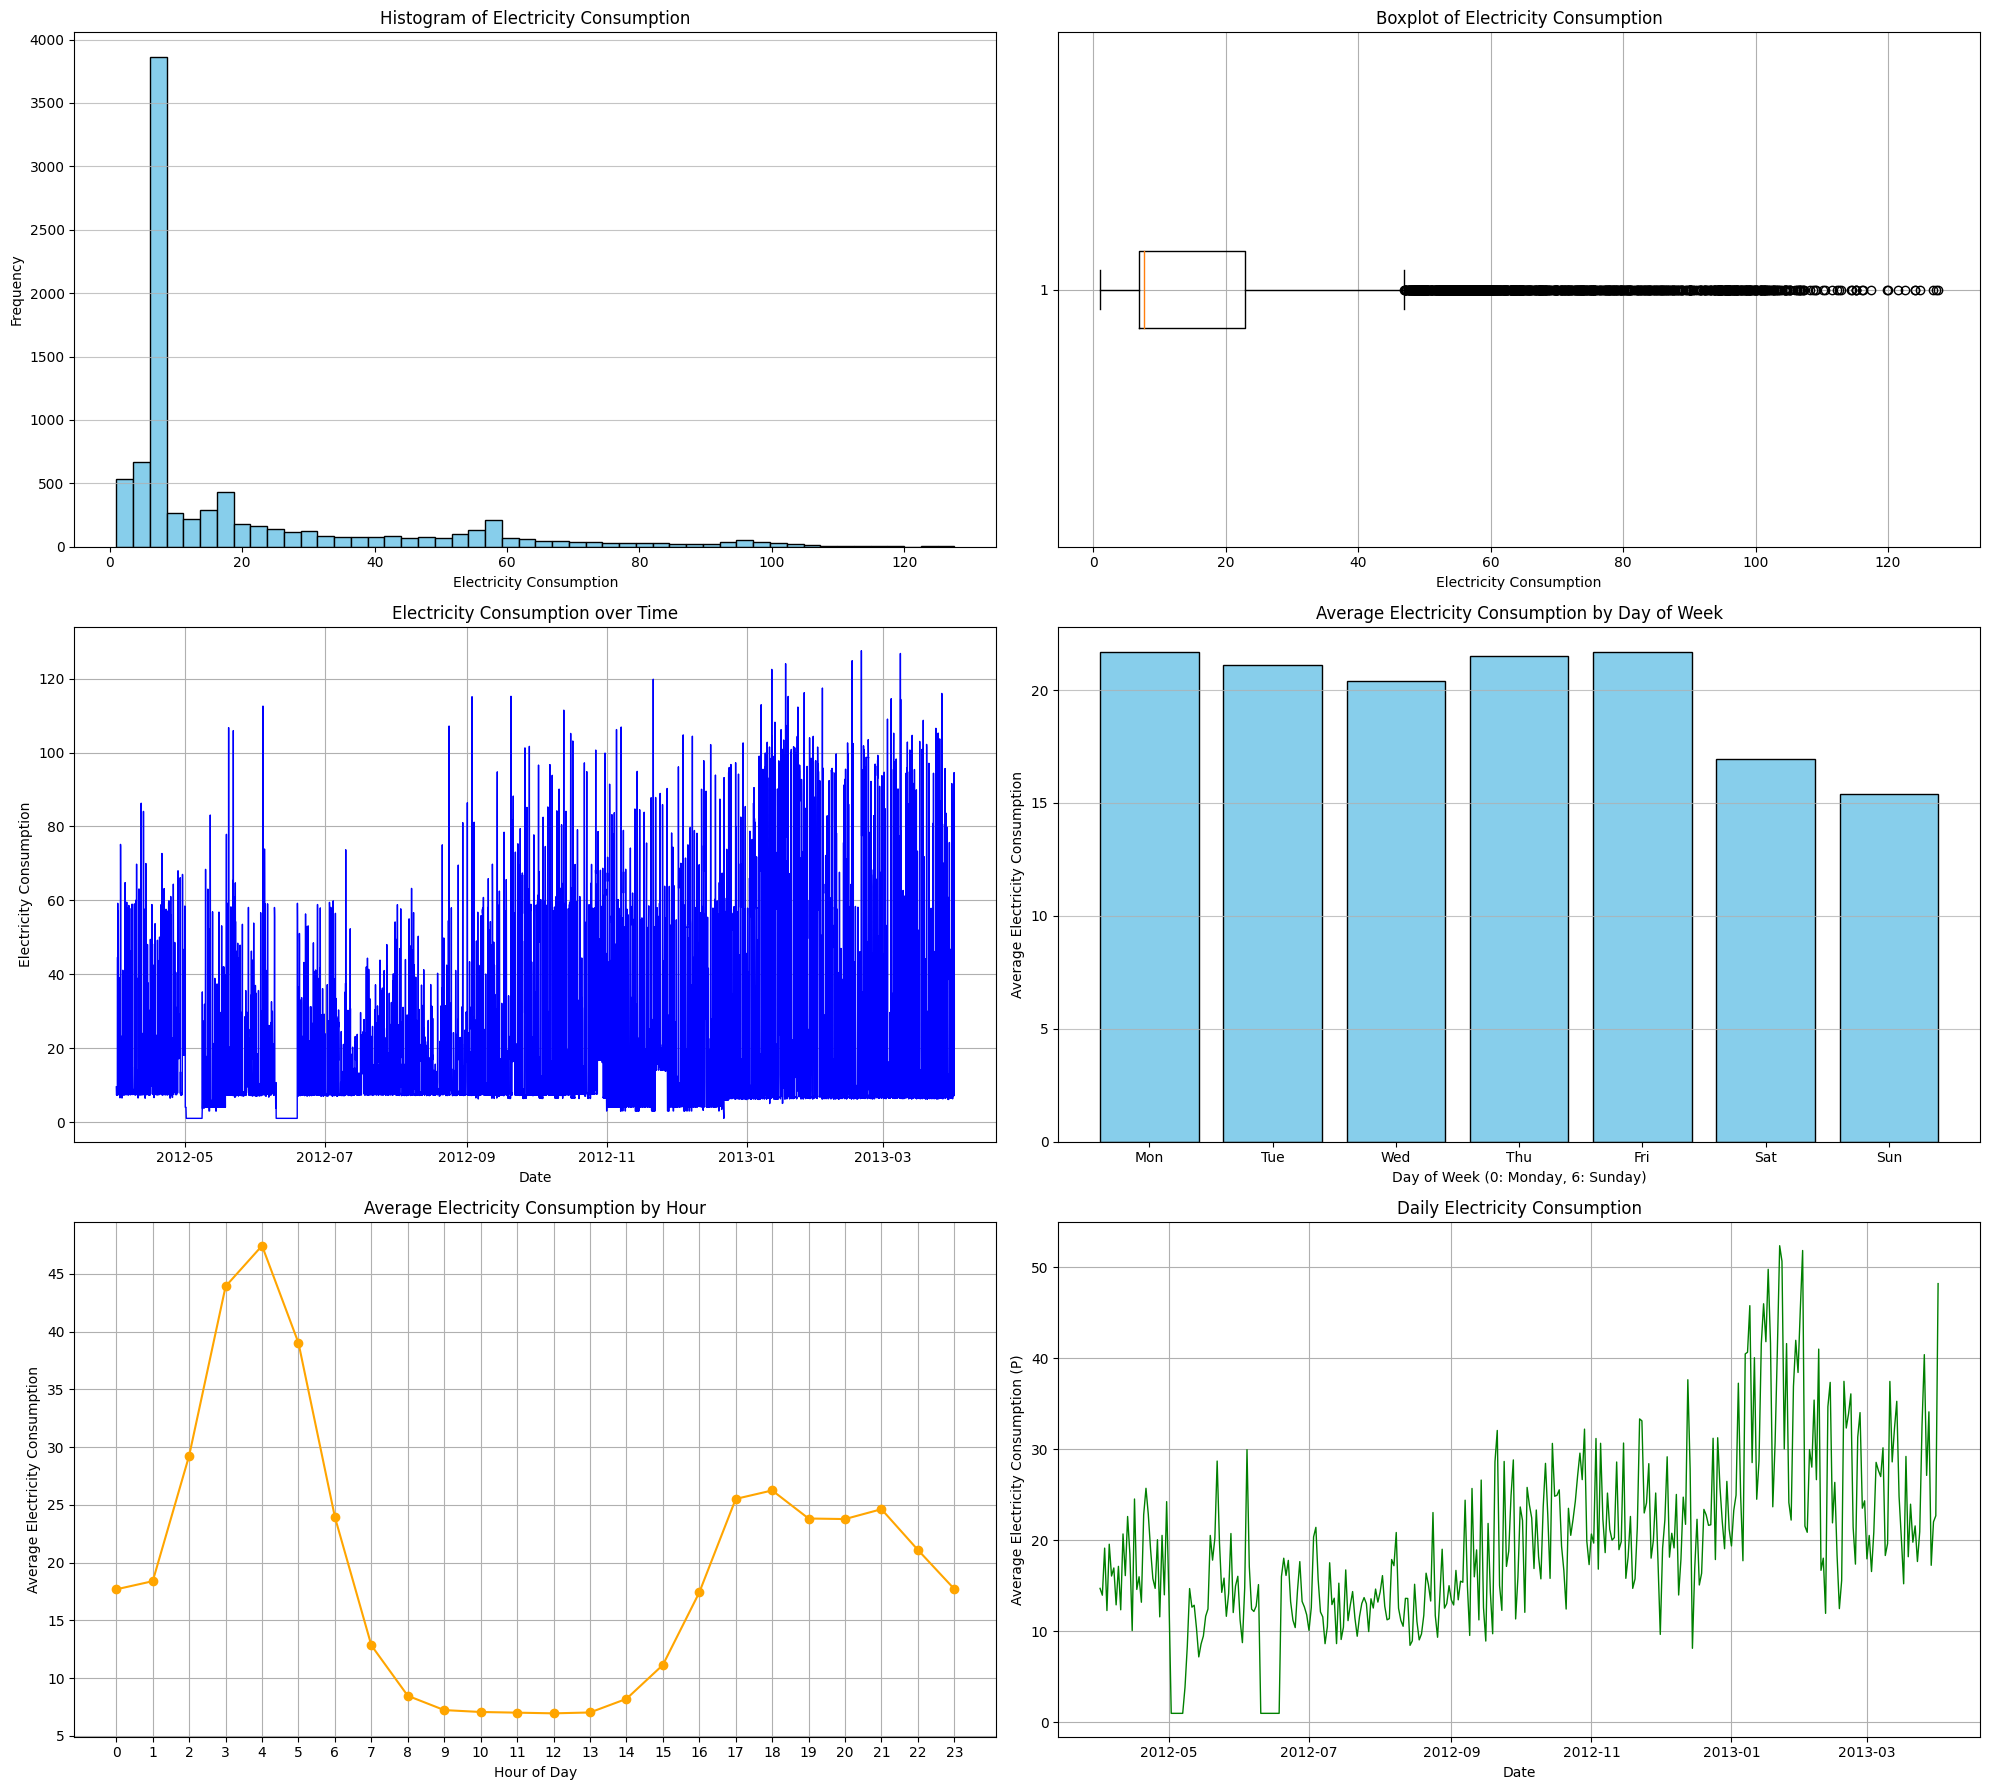

In [ ]:
# 1. 데이터 품질 확인

# 1.1. 결측치 확인
missing_values = df_year.isnull().sum()
print("결측치 개수:")
print(missing_values)

# 1.2. 0값 확인
zero_values = (df_year == 0).sum()
print("\n0값 개수:")
print(zero_values)

# 1.3. 데이터 통계량 확인
print("\n데이터 통계량:")
print(df_year.describe())

# 2. 데이터 시각화: 6개의 그래프를 서브플롯으로 구성
fig, axs = plt.subplots(3, 2, figsize=(20, 18))  # 3행 2열의 서브플롯 생성

# 2.1. 히스토그램으로 데이터 분포 확인
axs[0, 0].hist(df_year['P'], bins=50, color='skyblue', edgecolor='black')
axs[0, 0].set_xlabel('Electricity Consumption')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].set_title('Histogram of Electricity Consumption')
axs[0, 0].grid(axis='y', alpha=0.75)

# 2.2. 상자 그림(Boxplot)으로 이상치 확인
axs[0, 1].boxplot(df_year['P'], vert=False)
axs[0, 1].set_xlabel('Electricity Consumption')
axs[0, 1].set_title('Boxplot of Electricity Consumption')
axs[0, 1].grid(True)

# 2.3. 시간에 따른 전력 소비량 변화 시각화
axs[1, 0].plot(df_year.index, df_year['P'], color='blue', linewidth=1)
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Electricity Consumption')
axs[1, 0].set_title('Electricity Consumption over Time')
axs[1, 0].grid(True)

# 2.4. 요일별 전력 소비량 평균 비교
df_year['day_of_week'] = df_year.index.dayofweek

# 요일별 평균 전력 소비량 계산
mean_consumption_by_day = df_year.groupby('day_of_week')['P'].mean()

axs[1, 1].bar(mean_consumption_by_day.index, mean_consumption_by_day.values, color='skyblue', edgecolor='black')
axs[1, 1].set_xlabel('Day of Week (0: Monday, 6: Sunday)')
axs[1, 1].set_ylabel('Average Electricity Consumption')
axs[1, 1].set_title('Average Electricity Consumption by Day of Week')
axs[1, 1].set_xticks(mean_consumption_by_day.index)
axs[1, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axs[1, 1].grid(axis='y', alpha=0.75)

# 2.5. 시간대별 전력 소비량 평균 비교
# 'hour' 컬럼 추가 (0-23)
df_year['hour'] = df_year.index.hour

# 시간대별 평균 전력 소비량 계산
mean_consumption_by_hour = df_year.groupby('hour')['P'].mean()

axs[2, 0].plot(mean_consumption_by_hour.index, mean_consumption_by_hour.values, marker='o', linestyle='-', color='orange')
axs[2, 0].set_xlabel('Hour of Day')
axs[2, 0].set_ylabel('Average Electricity Consumption')
axs[2, 0].set_title('Average Electricity Consumption by Hour')
axs[2, 0].set_xticks(range(0, 24))
axs[2, 0].grid(True)

# 2.6. 하루 단위로 데이터 샘플링 및 시각화
df_daily = df_year.resample('D').mean()

axs[2, 1].plot(df_daily.index, df_daily['P'], color='green', linewidth=1)
axs[2, 1].set_xlabel('Date')
axs[2, 1].set_ylabel('Average Electricity Consumption (P)')
axs[2, 1].set_title('Daily Electricity Consumption')
axs[2, 1].grid(True)

# 레이아웃 조정 및 플롯 표시
plt.tight_layout()
plt.show()


In [ ]:
# 주, 시간 column 없애기. (필요에 따라 주석처리 후 사용)
df_year = df_year.drop(['day_of_week', 'hour'], axis=1)

# csv파일로 저장
df_year.to_csv('/content/drive/MyDrive/Colab Notebooks/data/Electricity_B2E_processed.csv')